# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-04-16 05:20:28--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  36.1MB/s    in 6.1s    

2021-04-16 05:20:35 (28.6 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-04-16 05:20:35--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  16.0MB/s    in 3.8s    

2021-04-16 05:20:38 (16.1 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-04-16 05:20:38--
Total wall clock time: 10s
Downloaded: 2 files, 235M in

In [2]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [51]:
batch_size = 32

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [52]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, sheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = float(loss_accum / i_step)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if not sheduler is None:
            sheduler.step(val_accuracy)

        loss_history.append(ave_loss)
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch: %d, Average loss: %f, Train accuracy: %f, Val accuracy: %f" 
              % (epoch, ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0

    for x, y in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)  
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    
    return float(correct_samples) / total_samples

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 0.838227, Train accuracy: 0.733099, Val accuracy: 0.770869
Epoch: 1, Average loss: 0.652211, Train accuracy: 0.800822, Val accuracy: 0.802334
Epoch: 2, Average loss: 0.588906, Train accuracy: 0.822987, Val accuracy: 0.818784
Epoch: 3, Average loss: 0.549236, Train accuracy: 0.835034, Val accuracy: 0.823562
Epoch: 4, Average loss: 0.520964, Train accuracy: 0.843804, Val accuracy: 0.819876


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

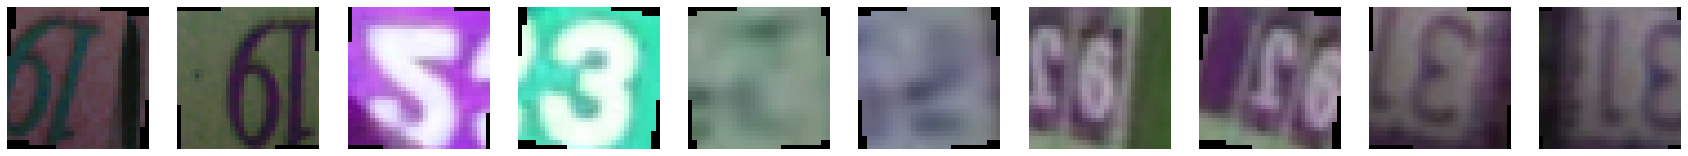

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=transforms.InterpolationMode.BILINEAR),
])

data_aug_vis = dset.SVHN('./', transform=tfs)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [53]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)


In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation
loss_history_aug, train_history_aug, val_history_aug = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Epoch: 0, Average loss: 1.129444, Train accuracy: 0.631232, Val accuracy: 0.734694
Epoch: 1, Average loss: 0.935386, Train accuracy: 0.697795, Val accuracy: 0.754283
Epoch: 2, Average loss: 0.876157, Train accuracy: 0.717674, Val accuracy: 0.754146
Epoch: 3, Average loss: 0.843248, Train accuracy: 0.729908, Val accuracy: 0.754488
Epoch: 4, Average loss: 0.813180, Train accuracy: 0.739890, Val accuracy: 0.741315


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(2),    
        nn.Conv2d(16, 120, 5),
        nn.LeakyReLU(inplace=True),
        Flattener(),
        nn.Linear(120, 84),
        nn.LeakyReLU(inplace=True),
        nn.Linear(84, 10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Epoch: 0, Average loss: 1.348350, Train accuracy: 0.543101, Val accuracy: 0.789161
Epoch: 1, Average loss: 0.549987, Train accuracy: 0.833703, Val accuracy: 0.863422
Epoch: 2, Average loss: 0.458908, Train accuracy: 0.864400, Val accuracy: 0.878780
Epoch: 3, Average loss: 0.411691, Train accuracy: 0.878101, Val accuracy: 0.877551
Epoch: 4, Average loss: 0.372735, Train accuracy: 0.889807, Val accuracy: 0.887448
Epoch: 5, Average loss: 0.347727, Train accuracy: 0.895301, Val accuracy: 0.894000
Epoch: 6, Average loss: 0.327728, Train accuracy: 0.903133, Val accuracy: 0.896253
Epoch: 7, Average loss: 0.314056, Train accuracy: 0.906375, Val accuracy: 0.893659
Epoch: 8, Average loss: 0.298133, Train accuracy: 0.910845, Val accuracy: 0.896321
Epoch: 9, Average loss: 0.285396, Train accuracy: 0.913217, Val accuracy: 0.885127


# Подбор гиперпараметров

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

from itertools import product

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3]
anneal_coeff = 0.2
anneal_epochs = [4, 16]
reg = [1e-4, 1e-5]

batch_size = 64
epoch_num = 10

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 
num = 1;

for lr, an_ep, re in product(learning_rates, anneal_epochs, reg):
    header = f"--- Model: {num}, with params: learning rate = {lr}, anneal epochs = {an_ep}, regularization = {re}"
    print(header)
    
    params = Hyperparams(lr, an_ep, re)
    model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(2),
        nn.Conv2d(6, 16, 5),
        nn.LeakyReLU(inplace=True),
        nn.MaxPool2d(2),    
        nn.Conv2d(16, 120, 5),
        nn.LeakyReLU(inplace=True),
        Flattener(),
        nn.Linear(120, 84),
        nn.LeakyReLU(inplace=True),
        nn.Linear(84, 10)
    )
    model.type(torch.cuda.FloatTensor)
    model.to(device)
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=re)
    lr_lambda = lambda epoch: anneal_coeff if epoch % an_ep == 0 else 1.0 
    sheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda)

    loss_history, train_history, val_history = train_model(
        model, train_aug_loader, val_loader, loss, optimizer, epoch_num, sheduler)
    
    run_record[params] = RunResult(model, train_history, val_history, val_history[-1])
    num += 1


# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!



--- Model: 1, with params: learning rate = 0.1, anneal epochs = 4, regularization = 0.0001


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0, Average loss: 1.408111, Train accuracy: 0.519776, Val accuracy: 0.795509
Epoch: 1, Average loss: 0.568069, Train accuracy: 0.828362, Val accuracy: 0.850454
Epoch: 2, Average loss: 0.466939, Train accuracy: 0.861516, Val accuracy: 0.861852
Epoch: 3, Average loss: 0.419898, Train accuracy: 0.875098, Val accuracy: 0.881783
Epoch: 4, Average loss: 0.388038, Train accuracy: 0.884926, Val accuracy: 0.883080
Epoch: 5, Average loss: 0.364372, Train accuracy: 0.891445, Val accuracy: 0.885469
Epoch: 6, Average loss: 0.342800, Train accuracy: 0.897246, Val accuracy: 0.886083
Epoch: 7, Average loss: 0.323417, Train accuracy: 0.903065, Val accuracy: 0.897823
Epoch: 8, Average loss: 0.313759, Train accuracy: 0.906358, Val accuracy: 0.896185
Epoch: 9, Average loss: 0.297741, Train accuracy: 0.910862, Val accuracy: 0.897823
--- Model: 2, with params: learning rate = 0.1, anneal epochs = 4, regularization = 1e-05
Epoch: 0, Average loss: 1.386222, Train accuracy: 0.528939, Val accuracy: 0.8236

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.1, anneal_epochs=16, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [54]:
my_model = nn.Sequential( #32x32
        nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(inplace=True), 
        nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        #-----------------------
        nn.MaxPool2d(2), #16x16
        #---------------------
        nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(inplace=True), 
        nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        #--------------------
        nn.MaxPool2d(2), #8x8
        #----------------------
        nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        #--------------------
        nn.MaxPool2d(2), #4x4
        #----------------------
        nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        #--------------------
        nn.MaxPool2d(2),#2x2
        #----------------------
        nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
        nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        #--------------------
        nn.MaxPool2d(2), #1x1
        #--------------------
        Flattener(),
        #----------------------
        nn.Linear(128, 512), nn.ReLU(inplace=True),
        nn.BatchNorm1d(512),
        nn.Linear(512, 10)
)

my_model.type(torch.cuda.FloatTensor)
my_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adadelta(my_model.parameters(), lr=1e-1, weight_decay=1e-2)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=3, threshold=0.01, verbose=True)

In [55]:
loss_history, train_history, val_history = train_model(my_model, train_aug_loader , val_loader, loss, optimizer, 15, sheduler)

Epoch: 0, Average loss: 1.319301, Train accuracy: 0.540986, Val accuracy: 0.846632
Epoch: 1, Average loss: 0.495803, Train accuracy: 0.852234, Val accuracy: 0.892567
Epoch: 2, Average loss: 0.406759, Train accuracy: 0.883613, Val accuracy: 0.904307
Epoch: 3, Average loss: 0.367912, Train accuracy: 0.896581, Val accuracy: 0.909358
Epoch     5: reducing learning rate of group 0 to 8.0000e-02.
Epoch: 4, Average loss: 0.345531, Train accuracy: 0.904856, Val accuracy: 0.923555
Epoch: 5, Average loss: 0.307005, Train accuracy: 0.918404, Val accuracy: 0.927991
Epoch: 6, Average loss: 0.292341, Train accuracy: 0.922499, Val accuracy: 0.923213
Epoch: 7, Average loss: 0.284874, Train accuracy: 0.924445, Val accuracy: 0.928606
Epoch     9: reducing learning rate of group 0 to 6.4000e-02.
Epoch: 8, Average loss: 0.275909, Train accuracy: 0.926322, Val accuracy: 0.927513
Epoch: 9, Average loss: 0.253291, Train accuracy: 0.934051, Val accuracy: 0.936182
Epoch: 10, Average loss: 0.244141, Train accur

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [56]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(my_model_2, test_loader)
print(f"Final test accuracy {final_test_accuracy: .4f} ")

Final test accuracy  0.9390 


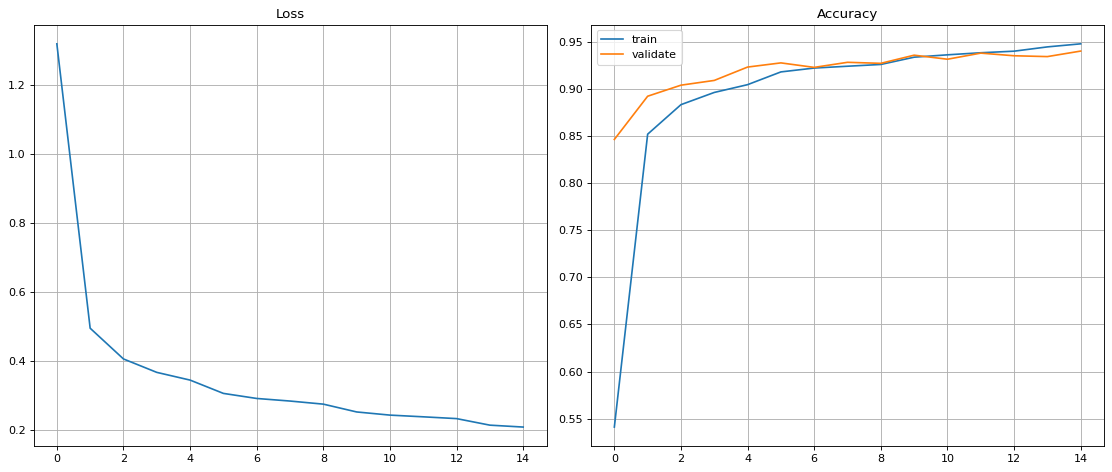

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6), dpi=80)
plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(loss_history)
plt.grid()

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(train_history, label="train")
plt.plot(val_history, label="validate")
plt.legend()
plt.grid()

plt.tight_layout()